# Story Talker

## 用 PaddleOCR 识别图片中的文字

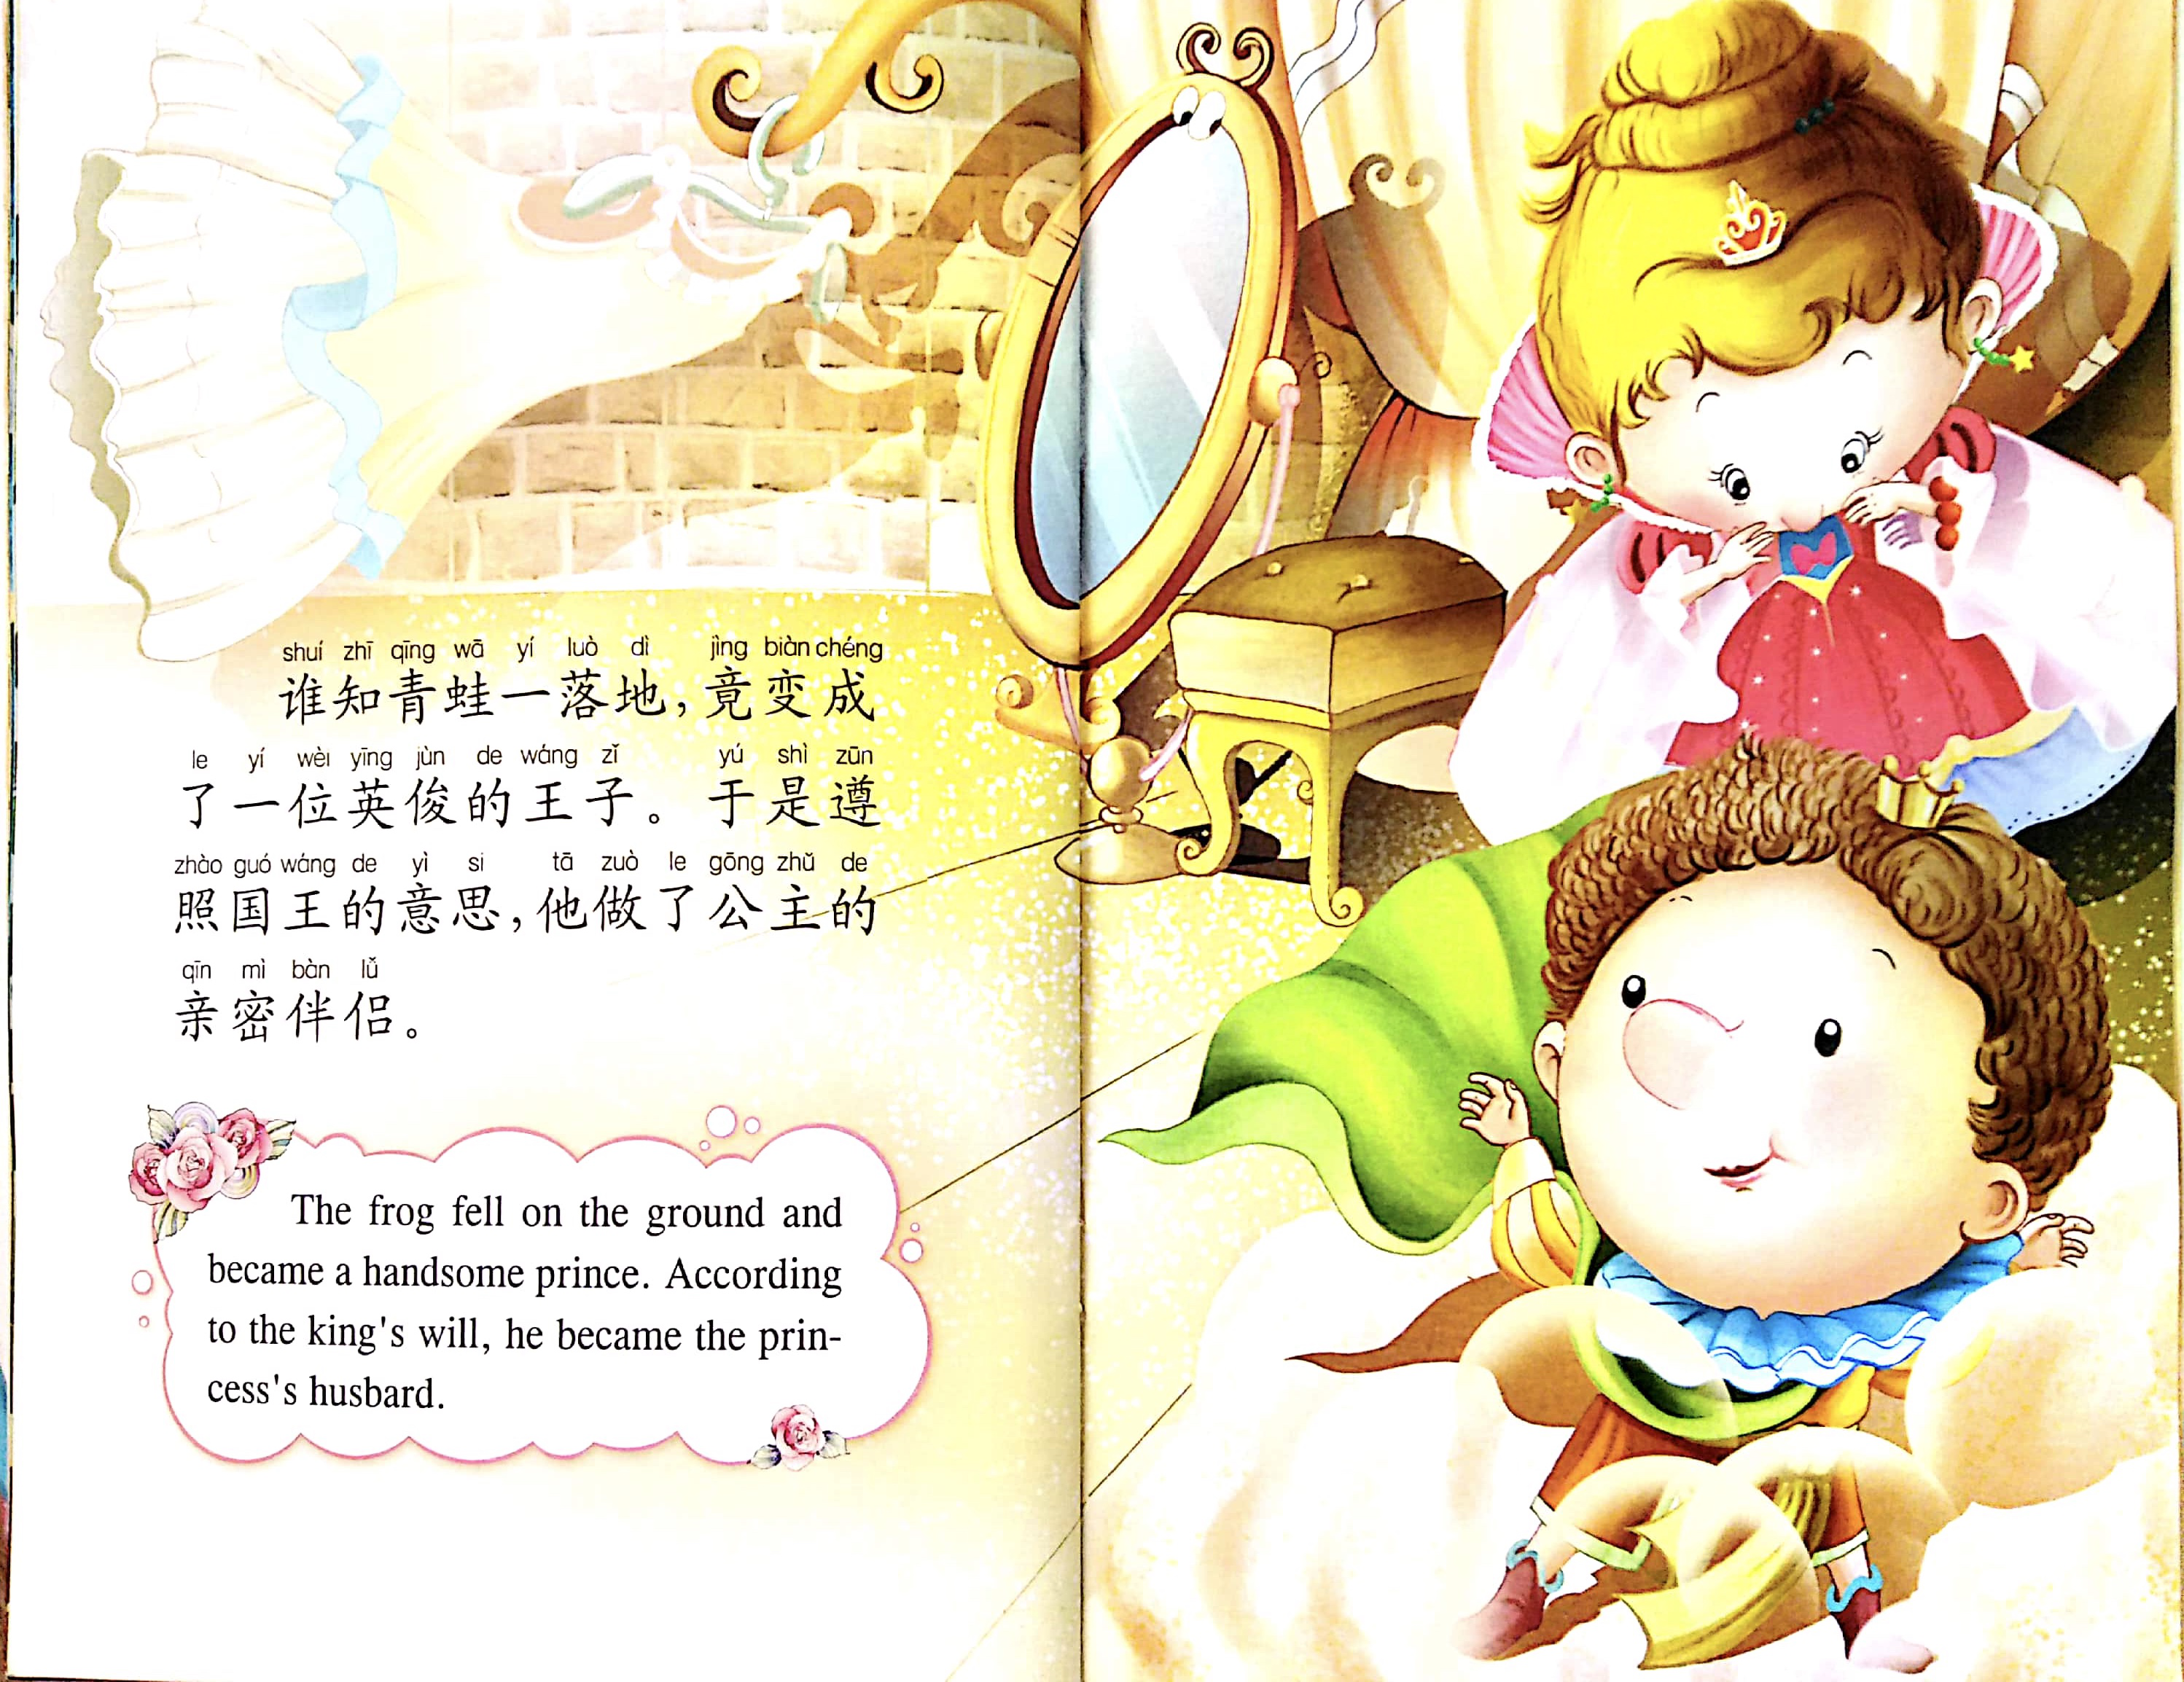

In [23]:
from PIL import Image
img_path = 'source/frog_prince.jpg'
im = Image.open(img_path)
im.show()

## 使用 TTS 合成的音频

In [49]:
import IPython.display as dp
dp.Audio("source/ocr.wav")

<font size=4>具体实现代码请参考: https://github.com/DeepSpeech/demos/story_talker/run.sh<font>

# 元宇宙来袭，构造你的虚拟人！

## 使用 PaddleGAN 合成的唇形视频

In [28]:
from IPython.display import HTML
html_str = '''
<video controls width="650" height="365" src="{}">animation</video>
'''.format("output/tts_lips.mp4")
dp.display(HTML(html_str))

<font size=4>具体实现代码请参考: https://github.com/DeepSpeech/demos/metaverse/run.sh<font>

# 前言
<br></br>
近年来，随着深度学习算法上的进步以及不断丰厚的硬件资源条件，**文本转语音（Text-To-Speech, TTS）** 技术在智能语音助手、虚拟娱乐等领域得到了广泛的应用。本教程将结合背景知识，让用户能够使用PaddlePaddle完成文本转语音任务，并结合光学字符识别（Optical Character Recognition，OCR）、自然语言处理（Natural Language Processing，NLP）等技术“听”书、让名人开口说话。

<br></br>
## 背景知识
<br></br>
为了更好地了解文本转语音任务的要素，我们先简要地回顾一下文本转语音的发展历史。如果你对此已经有所了解，或希望能尽快使用代码实现，请跳至第二章。

<br></br>
### 定义
<br></br>
<!----
Note: 
1.此句抄自 [李沐Dive into Dive Learning](https://zh-v2.d2l.ai/chapter_introduction/index.html)
2.修改参考A survey on Neural Speech Sysnthesis.
---> 
<font size=4> 文本转语音，又称语音合成（Speech Sysnthesis），指的是将一段文本按照一定需求转化成对应的音频，这种特性决定了的输出数据比输入输入长得多。文本转语音是一项包含了语义学、声学、数字信号处理以及机器学习的等多项学科的交叉任务。虽然辨识低质量音频文件的内容对人类来说很容易，但这对计算机来说并非易事。
</font>

> Note: 这里可以提供一下资料出处嘛？ 2021/11/09
<br></br>

按照不同的应用需求，更广义的语音合成研究包括：
- <font size=4>语音转换（Voice Transformation/Conversion）</font>
    - 说话人转换
    - 语音到歌唱转换（Speech to Singing）
    - 语音情感转换
    - 口音转换
- <font size=4>歌唱合成 （Singing Synthesis）</font>
    - <font size=4>歌词到歌唱转换（Text/Lyric to Singing）</font>
- <font size=4>可视语音合成（Visual Speech Synthesis）</font>

<br></br>
### 发展历史
<br></br>
<!--
以下摘自维基百科 https://en.wikipedia.org/wiki/Speech_synthesis
--->
#### 机械式语音合成（19世纪及以前）
在第二次工业革命之前，语音的合成主要以机械式的音素合成为主。1779年，德裔丹麦科学家 Christian Gottlieb Kratzenstein 建造了人类的声道模型，使其可以产生五个长元音。1791年， Wolfgang von Kempelen 添加了唇和舌的模型，使其能够发出辅音和元音。
#### 电子语音合成（20世纪30年代）
贝尔实验室于20世纪30年代发明了声码器（Vocoder），将语音自动分解为音调和共振，此项技术由 Homer Dudley 改进为键盘式合成器并于 1939年纽约世界博览会展出。
#### 电子语音合成
第一台基于计算机的语音合成系统起源于 20 世纪 50 年代。1961 年，IBM 的 John Larry Kelly，以及 Louis Gerstman 使用 IBM 704 计算机合成语音，成为贝尔实验室最著名的成就之一。 1975年，第一代语音合成系统之一 —— MUSA（MUltichannel Speaking Automation）问世，其由一个独立的硬件和配套的软件组成。1978年发行的第二个版本也可以进行无伴奏演唱。90 年代的主流是采用 MIT 和贝尔实验室的系统，并结合自然语言处理模型。
> Note: 这里插一张timeline图
#### 当前的主流方法

- <font size=4>基于统计参数的语音合成</font>
    - <font size=4>隐马尔可夫模型（Hidden Markov Model,HMM）</font>
    - <font size=4>深度学习网络（Deep Neural Network，DNN）</font>
- <font size=4>波形拼接语音合成</font>
 
- <font size=4>混合方法</font>
   - <font size=4>参数轨迹指导的波形拼接</font>
- <font size=4>端到端神经网络语音合成</font>
  - <font size=4>声学模型 + 声码器</font>
  - <font size=4>“完全”端到端方法</font>

<br></br>
## 基于深度学习的语音合成技术
<br></br>
### 语音合成基本知识
<br></br>
![信号处理流水线](source/signal_pipeline.png)
<br></br>
<font size=4>语音合成流水线包含 <font color="#ff0000">**文本前端（Text Frontend）**</font> 、<font color="#ff0000">**声学模型（Acoustic Model）**</font> 和 <font color="#ff0000">**声码器（Vocoder）**</font> 三个主要模块:</font>
- <font size=4>通过文本前端模块将原始文本转换为字符/音素。</font>
- <font size=4>通过声学模型将字符/音素转换为声学特征，如线性频谱图、mel 频谱图、LPC 特征等。</font>
- <font size=4>通过声码器将声学特征转换为波形。</font>
<br></br>
<img style="float: center;" src="source/tts_pipeline.png" width="85%"/>

# 实践
<br></br>
<font size=4>环境安装请参考: https://github.com/PaddlePaddle/DeepSpeech/blob/develop/docs/source/install.md</font>

<br></br>

<font size=4>使用 **PaddleSpeech** 提供的预训练模型合成一句中文。</font>


## step 0 准备

### 获取预训练模型

In [1]:
!mkdir download
!wget -P download https://paddlespeech.bj.bcebos.com/Parakeet/pwg_baker_ckpt_0.4.zip
!unzip -d download download/pwg_baker_ckpt_0.4.zip
!wget -P download https://paddlespeech.bj.bcebos.com/Parakeet/fastspeech2_nosil_baker_ckpt_0.4.zip
!unzip -d download download/fastspeech2_nosil_baker_ckpt_0.4.zip

mkdir: cannot create directory 'download': File exists
--2021-11-06 13:50:44--  https://paddlespeech.bj.bcebos.com/Parakeet/pwg_baker_ckpt_0.4.zip
Connecting to 172.19.56.199:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 15774206 (15M) [application/zip]
Saving to: 'download/pwg_baker_ckpt_0.4.zip'

pwg_baker_ckpt_0.4. 100%[===================>]  15.04M   454KB/s    in 42s     

2021-11-06 13:51:30 (364 KB/s) - 'download/pwg_baker_ckpt_0.4.zip' saved [15774206/15774206]

Archive:  download/pwg_baker_ckpt_0.4.zip
   creating: download/pwg_baker_ckpt_0.4/
  inflating: download/pwg_baker_ckpt_0.4/pwg_default.yaml  
  inflating: download/pwg_baker_ckpt_0.4/pwg_snapshot_iter_400000.pdz  
  inflating: download/pwg_baker_ckpt_0.4/pwg_stats.npy  
--2021-11-06 13:51:31--  https://paddlespeech.bj.bcebos.com/Parakeet/fastspeech2_nosil_baker_ckpt_0.4.zip
Connecting to 172.19.56.199:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 488622795 (466

### 查看预训练模型的结构

In [2]:
!tree download/pwg_baker_ckpt_0.4
!tree download/fastspeech2_nosil_baker_ckpt_0.4

download/pwg_baker_ckpt_0.4
|-- pwg_default.yaml
|-- pwg_snapshot_iter_400000.pdz
`-- pwg_stats.npy

0 directories, 3 files
download/fastspeech2_nosil_baker_ckpt_0.4
|-- default.yaml
|-- phone_id_map.txt
|-- snapshot_iter_76000.pdz
`-- speech_stats.npy

0 directories, 4 files


### 导入 Python 包

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import sys
import warnings
warnings.filterwarnings('ignore')
# PaddleSpeech 项目根目录放到 python 路径中
sys.path.insert(0,"../../../")

In [2]:
import argparse
import os
from pathlib import Path
import IPython.display as dp
import matplotlib.pyplot as plt
import numpy as np
import paddle
import soundfile as sf
import yaml
from paddlespeech.t2s.frontend.zh_frontend import Frontend
from paddlespeech.t2s.models.fastspeech2 import FastSpeech2
from paddlespeech.t2s.models.fastspeech2 import FastSpeech2Inference
from paddlespeech.t2s.models.parallel_wavegan import PWGGenerator
from paddlespeech.t2s.models.parallel_wavegan import PWGInference
from paddlespeech.t2s.modules.normalizer import ZScore
from yacs.config import CfgNode

/home/yuantian01/yt_py37/lib/python3.7/site-packages/scipy/linalg/__init__.py:212: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/home/yuantian01/yt_py37/lib/python3.7/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/home/yuantian01/yt_py37/lib/python3.7/site-packages/librosa/core/constantq.py:1059: DeprecationWarni

### 设置预训练模型的路径

In [3]:
fastspeech2_config = "download/fastspeech2_nosil_baker_ckpt_0.4/default.yaml"
fastspeech2_checkpoint = "download/fastspeech2_nosil_baker_ckpt_0.4/snapshot_iter_76000.pdz"
fastspeech2_stat = "download/fastspeech2_nosil_baker_ckpt_0.4/speech_stats.npy"
pwg_config = "download/pwg_baker_ckpt_0.4/pwg_default.yaml"
pwg_checkpoint = "download/pwg_baker_ckpt_0.4/pwg_snapshot_iter_400000.pdz"
pwg_stat = "download/pwg_baker_ckpt_0.4/pwg_stats.npy"
phones_dict = "download/fastspeech2_nosil_baker_ckpt_0.4/phone_id_map.txt"
# 读取 conf 文件并结构化
with open(fastspeech2_config) as f:
    fastspeech2_config = CfgNode(yaml.safe_load(f))
with open(pwg_config) as f:
    pwg_config = CfgNode(yaml.safe_load(f))
print("========Config========")
print(fastspeech2_config)
print("---------------------")
print(pwg_config)

========Config========
batch_size: 64
f0max: 400
f0min: 80
fmax: 7600
fmin: 80
fs: 24000
max_epoch: 1000
model:
  adim: 384
  aheads: 2
  decoder_normalize_before: True
  dlayers: 4
  dunits: 1536
  duration_predictor_chans: 256
  duration_predictor_kernel_size: 3
  duration_predictor_layers: 2
  elayers: 4
  encoder_normalize_before: True
  energy_embed_dropout: 0.0
  energy_embed_kernel_size: 1
  energy_predictor_chans: 256
  energy_predictor_dropout: 0.5
  energy_predictor_kernel_size: 3
  energy_predictor_layers: 2
  eunits: 1536
  init_dec_alpha: 1.0
  init_enc_alpha: 1.0
  init_type: xavier_uniform
  pitch_embed_dropout: 0.0
  pitch_embed_kernel_size: 1
  pitch_predictor_chans: 256
  pitch_predictor_dropout: 0.5
  pitch_predictor_kernel_size: 5
  pitch_predictor_layers: 5
  positionwise_conv_kernel_size: 3
  positionwise_layer_type: conv1d
  postnet_chans: 256
  postnet_filts: 5
  postnet_layers: 5
  reduction_factor: 1
  stop_gradient_from_energy_predictor: False
  stop_gradient

## step1 文本前端
<br></br>

<font size=4>一个文本前端模块主要包含</font>:
- <font size=4>分段（Text Segmentation）</font>

- <font size=4>文本正则化（Text Normalization, TN）</font>

- <font size=4>分词（Word Segmentation, 主要是在中文中）</font>

- <font size=4>词性标注（Part-of-Speech, PoS）</font>
- <font size=4>韵律预测（Prosody）</font>
- <font size=4>字音转换（Grapheme-to-Phoneme，G2P）</font>
<br></br>
<font size=2>（Grapheme: **语言**书写系统的最小有意义单位; Phoneme: 区分单词的最小**语音**单位）</font>
    - <font size=4>多音字（Polyphone）</font>
    - <font size=4>变调（Tone Sandhi）</font>
        - <font size=4>“一”、“不”变调</font>
        - <font size=4>三声变调</font>
        - <font size=4>轻声变调</font>
        - <font size=4>儿化音</font>
        - <font size=4>方言</font>
- ...
<br></br>

<font size=4>（输入给声学模型之前，还需要把音素序列转换为 id）</font>

<br></br>
<font size=4>其中最重要的模块是<font color="#ff0000"> 文本正则化 </font>模块和<font color="#ff0000"> 字音转换（TTS 中更常用 G2P代指） </font>模块。</font>

<br></br>

<font size=4>各模块输出示例:</font>
```text
• Text: 全国一共有112所211高校
• Text Normalization: 全国一共有一百一十二所二一一高校
• Word Segmentation: 全国/一共/有/一百一十二/所/二一一/高校/
• G2P（注意此句中“一”的读音）:
    quan2 guo2 yi2 gong4 you3 yi4 bai3 yi1 shi2 er4 suo3 er4 yao1 yao1 gao1 xiao4
    （可以进一步把声母和韵母分开）
    q uan2 g uo2 y i2 g ong4 y ou3 y i4 b ai3 y i1 sh i2 er4 s uo3 er4 y ao1 y ao1 g ao1 x iao4
    （把音调和声韵母分开）
    q uan g uo y i g ong y ou y i b ai y i sh i er s uo er y ao y ao g ao x iao
    0 2 0 2 0 2 0 4 0 3 ...
• Prosody (prosodic words #1, prosodic phrases #2, intonation phrases #3, sentence #4):
    全国#2一共有#2一百#1一十二所#2二一一#1高校#4
    （分词的结果一般是固定的，但是不同人习惯不同，可能有不同的韵律）
```

<br></br>
<font size=4>文本前端模块的设计需要融入很多专业的或经验性的知识，人类在读文本的时候可以自然而然地读出正确的发音，但是这些计算机都是不知道的！</font>

<br></br>
<font size=4>分词:</font>
```text
我也想过过过儿过过的生活
我也想/过过/过儿/过过的/生活

货拉拉拉不拉拉布拉多
货拉拉/拉不拉/拉布拉多

南京市长江大桥
南京市长/江大桥
南京市/长江大桥
```
<font size=4>变调和儿化音：</font>
```
你要不要和我们一起出去玩？
你要不（2声）要和我们一（4声）起出去玩（儿）？

不好，我要一个人出去。
不（4声）好，我要一（2声）个人出去。

（以下每个词的所有字都是三声的，请你读一读，体会一下在读的时候，是否每个字都被读成了三声？）
纸老虎、虎骨酒、展览馆、岂有此理、手表厂有五种好产品
```
<font size=4>多音字（通常需要先正确分词）：</font>
```text
人要行，干一行行一行，一行行行行行;
人要是不行，干一行不行一行，一行不行行行不行。

佟大为妻子产下一女

海水朝朝朝朝朝朝朝落
浮云长长长长长长长消
```
<br></br>

<font size=4>PaddleSpeech TTS 文本前端解决方案:</font>
- <font size=4>文本正则: 规则</font>
- <font size=4>G2P:</font>
    - <font size=4>多音字模块: pypinyin/g2pM</font>
    - <font size=4>变调模块: 用分词 + 规则</font>

<br></br>
<font size=4>相关 examples:
    
https://github.com/PaddlePaddle/DeepSpeech/tree/develop/examples/other/tn
https://github.com/PaddlePaddle/DeepSpeech/tree/develop/examples/other/g2p</font>

<br></br>
<font size=4>（未来计划推出基于深度学习的文本前端模块）</font>

### 构造文本前端对象

In [4]:
# 传入 phones_dict 会把相应的 phones 转换成 phone_ids
frontend = Frontend(phone_vocab_path=phones_dict)
print("Frontend done!")

Frontend done!


### 调用文本前端

In [119]:
input = "你好，欢迎使用百度飞桨框架进行深度学习研究！"
# text norm 时会进行分句，merge_sentences 表示把分句的结果合成一条
# 可以把 merge_sentences 设置为 False, 多个子句并行调用声学模型和声码器提升合成速度
input_ids = frontend.get_input_ids(input, merge_sentences=True, print_info=True,robot=True)
# 由于 merge_sentences=True, input_ids["phone_ids"][0] 即表示整句的 phone_ids
phone_ids = input_ids["phone_ids"][0]
print("phone_ids:")
print(phone_ids)

----------------------------
text norm results:
['你好，', '欢迎使用百度飞桨框架进行深度学习研究！']
----------------------------
g2p results:
[['n', 'i1', 'h', 'ao1', 'sp', 'h', 'uan1', 'ing1', 'sh', 'iii1', 'iong1', 'b', 'ai1', 'd', 'u1', 'f', 'ei1', 'j', 'iang1', 'k', 'uang1', 'j', 'ia1', 'j', 'in1', 'x', 'ing1', 'sh', 'en1', 'd', 'u1', 'x', 've1', 'x', 'i1', 'ian1', 'j', 'iou1', 'sp']]
----------------------------
phone_ids:
Tensor(shape=[39], dtype=int64, place=CUDAPlace(0), stop_gradient=True,
       [155, 72 , 71 , 27 , 179, 71 , 199, 125, 177, 113, 135, 37 , 7  , 40 ,
        183, 69 , 46 , 151, 87 , 152, 204, 151, 77 , 151, 120, 260, 125, 177,
        51 , 40 , 183, 260, 250, 260, 72 , 82 , 151, 140, 179])


## step1+ 文本前端深度学习化
<br></br>
<img style="float: center;" src="source/text_frontend_struct.png" width="100%"/>

## step2 声学模型
<br></br>
<font size=4>声学模型将字符/音素转换为声学特征，如线性频谱图、mel 频谱图、LPC 特征等，声学特征以 “帧” 为单位，一般一帧是 10ms 左右，一个音素一般对应 5~20 帧左右, 声学模型需要解决的是 <font color="#ff0000">“不等长序列间的映射问题”</font>，“不等长”是指，同一个人发不同音素的持续时间不同，同一个人在不同时刻说同一句话的语速可能不同，对应各个音素的持续时间不同，不同人说话的特色不同，对应各个音素的持续时间不同。这是一个困难的“一对多”问题。</font>
```
# 卡尔普陪外孙玩滑梯
000001|baker_corpus|sil 20 k 12 a2 4 er2 10 p 12 u3 12 p 9 ei2 9 uai4 15 s 11 uen1 12 uan2 14 h 10 ua2 11 t 15 i1 16 sil 20
```

<font size=4>声学模型主要分为自回归模型和非自回归模型，其中自回归模型在 `t` 时刻的预测需要依赖 `t-1` 时刻的输出作为输入，预测时间长，但是音质相对较好，非自回归模型不存在预测上的依赖关系，预测时间快，音质相对较差。</font>

<br></br>
<font size=4>主流声学模型发展的脉络:</font>
- <font size=4>自回归模型:</font>
    - <font size=4>Tacotron</font>
    - <font size=4>Tacotron2</font>
    - <font size=4>Transformer TTS</font>
- <font size=4>非自回归模型:</font>
    - <font size=4>FastSpeech</font>
    - <font size=4>SpeedySpeech</font>
    - <font size=4>FastPitch</font>
    - <font size=4>FastSpeech2</font>
    - ...
 
<br></br>
<font size=4>在本教程中，我们使用 `FastSpeech2` 作为声学模型。<font>
![FastSpeech2](source/fastspeech2.png)
<font size=4>PaddleSpeech TTS 实现的 FastSpeech2 与论文不同的地方在于，我们使用的的是 phone 级别的 `pitch` 和 `energy`(与 FastPitch 类似)。<font>
![FastPitch](source/fastpitch.png)
<font size=4>更多关于声学模型的发展及改进的介绍: https://paddlespeech.readthedocs.io/en/latest/tts/models_introduction.html<font>

### 初始化声学模型 FastSpeech2

In [6]:
with open(phones_dict, "r") as f:
    phn_id = [line.strip().split() for line in f.readlines()]
vocab_size = len(phn_id)
print("vocab_size:", vocab_size)
odim = fastspeech2_config.n_mels
model = FastSpeech2(
    idim=vocab_size, odim=odim, **fastspeech2_config["model"])
# 预训练好的参数赋值给模型
model.set_state_dict(paddle.load(fastspeech2_checkpoint)["main_params"])
# 推理阶段不启用 batch norm 和 dropout
model.eval()
# 读取数据预处理阶段数据集的均值和标准差
stat = np.load(fastspeech2_stat)
mu, std = stat
mu = paddle.to_tensor(mu)
std = paddle.to_tensor(std)
fastspeech2_normalizer = ZScore(mu, std)
# 构造包含 normalize 的新模型
fastspeech2_inference = FastSpeech2Inference(fastspeech2_normalizer, model)
fastspeech2_inference.eval()
print("FastSpeech2 done!")

vocab_size: 268


/home/yuantian01/yt_py37/lib/python3.7/site-packages/paddle/framework/io.py:415: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterable) and not isinstance(obj, (


FastSpeech2 done!


### 调用声学模型

shepe of mel (n_frames x n_mels):
[347, 80]


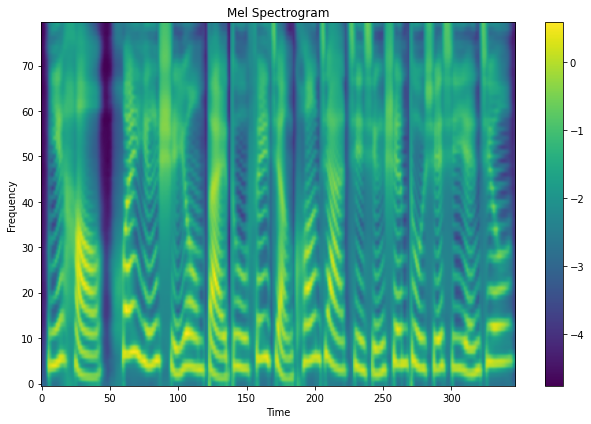

In [7]:
with paddle.no_grad():
    mel = fastspeech2_inference(phone_ids)
print("shepe of mel (n_frames x n_mels):")
print(mel.shape)
# 绘制声学模型输出的 mel 频谱
fig, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow(mel.T, aspect='auto',origin='lower')
fig.colorbar(im, ax=ax)
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.tight_layout()

## step3 声码器
<br></br>
<font size=4>声码器将声学特征转换为波形。声码器需要解决的是 <font color="#ff0000">“信息缺失的补全问题”</font>。信息缺失是指，在音频波形转换为频谱图的时候，存在**相位信息**的缺失，在频谱图转换为 mel 频谱图的时候，存在**频域压缩**导致的信息缺失；假设音频的采样率是16kHZ, 一帧的音频有 10ms，也就是说，1s 的音频有 16000 个采样点，而 1s 中包含 100 帧，每一帧有 160 个采样点，声码器的作用就是将一个频谱帧变成音频波形的 160 个采样点，所以声码器中一般会包含**上采样**模块。<font>
    
<br></br>
<font size=4>与声学模型类似，声码器也分为自回归模型和非自回归模型, 更细致的分类如下:<font>

- <font size=4>Autoregression<font>
    - <font size=4>WaveNet<font>
    - <font size=4>WaveRNN<font>
    - <font size=4>LPCNet<font>
- <font size=4>Flow<font>
    - <font size=4>WaveFlow<font>
    - <font size=4>WaveGlow<font>
    - <font size=4>FloWaveNet<font>
    - <font size=4>Parallel WaveNet<font>
- <font size=4>GAN<font>
    - <font size=4>WaveGAN<font>
    - <font size=4>arallel WaveGAN<font>
    - <font size=4>MelGAN<font>
    - <font size=4>HiFi-GAN<font>
- <font size=4>VAE
    - <font size=4>Wave-VAE<font>
- <font size=4>Diffusion<font>
    - <font size=4>WaveGrad<font>
    - <font size=4>DiffWave<font>

<br></br>
<font size=4>PaddleSpeech TTS 主要实现了百度的 `WaveFlow` 和一些主流的 GAN Vocoder, 在本教程中，我们使用 `Parallel WaveGAN` 作为声码器。<font>

<br></br> 
<img style="float: center;" src="source/pwgan.png" width="75%"/> 

<br></br>
<font size=4>各 GAN Vocoder 的生成器和判别器的 Loss 的区别如下表格所示:<font>
    
Model  | Generator Loss |Discriminator Loss
:-------------:| :------------:| :-----
Parallel Wave GAN| adversial loss <br> Feature Matching  | Multi-Scale Discriminator |
Mel GAN |adversial loss <br> Multi-resolution STFT loss  | adversial loss|
Multi-Band Mel GAN | adversial loss <br> full band Multi-resolution STFT loss <br> sub band Multi-resolution STFT loss |Multi-Scale Discriminator|
HiFi GAN |adversial loss <br> Feature Matching <br>  Mel-Spectrogram Loss | Multi-Scale Discriminator <br> Multi-Period Discriminato  |


### 初始化声码器 Parallel WaveGAN

In [8]:
vocoder = PWGGenerator(**pwg_config["generator_params"])
# 预训练好的参数赋值给模型
vocoder.set_state_dict(paddle.load(pwg_checkpoint)["generator_params"])
vocoder.remove_weight_norm()
# 推理阶段不启用 batch norm 和 dropout
vocoder.eval()
# 读取数据预处理阶段数据集的均值和标准差
stat = np.load(pwg_stat)
mu, std = stat
mu = paddle.to_tensor(mu)
std = paddle.to_tensor(std)
pwg_normalizer = ZScore(mu, std)
# 构造包含 normalize 的新模型
pwg_inference = PWGInference(pwg_normalizer, vocoder)
pwg_inference.eval()
print("Parallel WaveGAN done!")

Parallel WaveGAN done!


### 调用声码器

shepe of wav (time x n_channels):
[104100, 1]


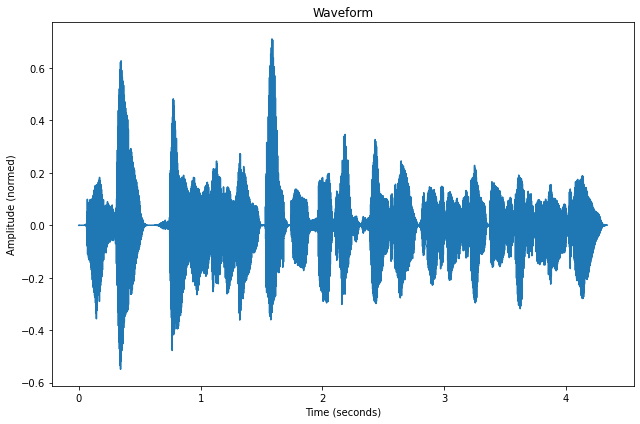

In [9]:
with paddle.no_grad():
    wav = pwg_inference(mel)
print("shepe of wav (time x n_channels):")
print(wav.shape)
# 绘制声码器输出的波形图
wave_data = wav.numpy().T
time = np.arange(0, wave_data.shape[1]) * (1.0 / fastspeech2_config.fs)
fig, ax = plt.subplots(figsize=(9, 6))
plt.plot(time, wave_data[0])
plt.title('Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (normed)')
plt.tight_layout()

### 播放音频

In [10]:
dp.Audio(wav.numpy().T, rate=fastspeech2_config.fs)

### 保存音频

In [11]:
!mkdir output
sf.write(
    "output/output.wav",
    wav.numpy(),
    samplerate=fastspeech2_config.fs)

mkdir: cannot create directory 'output': File exists


In [ ]:
# 实验代码，非教程部分
# change pitch

with paddle.no_grad():
    mel, d_outs, p_outs, e_outs = fastspeech2_inference(phone_ids, output_dpe=True)
    wav = pwg_inference(mel)
dp.Audio(wav.numpy().T, rate=fastspeech2_config.fs)

In [42]:
# 实验代码，非教程部分
# 变速，变调，机械音
# 机械音：输入的 token 都变成一声，pitch 变成 zero，duration 变成
# 输入一个参数搞定

phones = ['n', 'i1', 'h', 'ao1', 'sp', 'h', 'uan1', 'ing1', 'sh', 'iii1', 'iong1', 'b', 'ai1', 'd', 'u1', 'f', 'ei1', 'j', 'iang1', 'k', 'uang1', 'j', 'ia1', 'j', 'in1', 'x', 'ing1', 'sh', 'en1', 'd', 'u1', 'x', 've1', 'x', 'i1', 'ian1', 'j', 'iou1', 'sp']
phone_dict = {}
with open(phones_dict, "r") as f:
    phn_id = [line.strip().split() for line in f.readlines()]
for phn, id in phn_id:
    phone_dict[phn]=int(id)
    
vocab_size = len(phn_id)
phone_ids = [phone_dict[phn] for phn in phones]
phone_ids = paddle.to_tensor(phone_ids)
pitch_stats_path="/home/yuantian01/myPaddle/Parakeet/examples/fastspeech2/baker/dump/train/pitch_stats.npy"
pitch_mean, pitch_std = np.load(pitch_stats_path)
# print("p_outs:", p_outs)
# pitch 变换为 Hz 表示
# 在数据预处理的时候，是先求 log 再减均值除方差

# 变换为童声
# p = p * 1.5
# p 变为均值
# p = np.full(p.shape, p.mean())
# p = p -50
# p = np.zeros(p.shape)
# 变换为 fastspeech2 的输入
# p = (np.log(p) - pitch_mean)/pitch_std
# d = paddle.full(d_outs.shape, d_outs.mean())
# e = paddle.full(e_outs.shape, e_outs.mean())
# d 是可以控制的，p 要对输出的控制，需要输入 pitch 的均值方差文件
# p = paddle.to_tensor(p)
with paddle.no_grad():
    mel = fastspeech2_inference(phone_ids, d_ratio=1)
    wav = pwg_inference(mel)
dp.Audio(wav.numpy().T, rate=fastspeech2_config.fs)
    


In [121]:
sf.write(
    "output/ocr.wav",
    wav.numpy(),
    samplerate=fastspeech2_config.fs)

## step4 FastSpeech2 进阶 — 变调变速
<br></br>
<font size=3>FastSpeech2 模型可以个性化地调节音素时长、音调和能量，通过一些简单的调节就可以获得一些有意思的效果<font>

In [120]:
# jupyter 在一个 cell 显示多个音频
print("原始音频")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/parakeet_espnet_fs2_pwg_demo/tn_g2p/espent/001.wav"))
print("speed x 1.2")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/parakeet_espnet_fs2_pwg_demo/tn_g2p/espent/002.wav"))
print("speed x 0.8")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/parakeet_espnet_fs2_pwg_demo/tn_g2p/espent/002.wav"))
print("speed x 1.2(童声)")
dp.display(dp.Audio(url="https://paddlespeech.bj.bcebos.com/Parakeet/docs/demos/parakeet_espnet_fs2_pwg_demo/tn_g2p/espent/002.wav"))


原始音频


speed x 1.2


speed x 0.8


speed x 1.2(童声)


<font size=4>具体实现代码请参考: https://github.com/DeepSpeech/demos/style_fs2/run.sh<font>

<br></br>
# 用 PaddleSpeech 训练 TTS 模型
<br></br>
<font size=3>PaddleSpeech 的 examples 是按照 数据集/模型 的结构安排的:<font>
```text
examples   
|-- aishell3
|   |-- README.md
|   |-- tts3
|   `-- vc0
|-- csmsc
|   |-- README.md
|   |-- tts2
|   |-- tts3
|   |-- voc1
|   `-- voc3
```
<font size=3>我们在每个数据集的 README.md 介绍了子目录和模型的对应关系, 在 TTS 中有如下对应关系:<font>
```text
tts0 - Tactron2
tts1 - TransformerTTS
tts2 - SpeedySpeech
tts3 - FastSpeech2
voc0 - WaveFlow
voc1 - Parallel WaveGAN
voc2 - MelGAN
voc3 - MultiBand MelGAN
```
<br></br>
## 基于 CSMCS 数据集训练 FastSpeech2 模型
```bash
git clone https://github.com/PaddlePaddle/DeepSpeech.git
cd examples/csmsc/tts
```
<font size=3>根据 README.md, 下载 CSMCS 数据集和其对应的强制对齐文件, 并放置在对应的位置<font>
```bash
./run.sh
```
<font size=3>`run.sh` 中包含预处理、训练、合成、静态图推理等步骤:</font>

```bash
#!/bin/bash
set -e
source path.sh
gpus=0,1
stage=0
stop_stage=100
conf_path=conf/default.yaml
train_output_path=exp/default
ckpt_name=snapshot_iter_153.pdz

# with the following command, you can choice the stage range you want to run
# such as `./run.sh --stage 0 --stop-stage 0`
# this can not be mixed use with `$1`, `$2` ...
source ${MAIN_ROOT}/utils/parse_options.sh || exit 1

if [ ${stage} -le 0 ] && [ ${stop_stage} -ge 0 ]; then
    # prepare data
    bash ./local/preprocess.sh ${conf_path} || exit -1
fi
if [ ${stage} -le 1 ] && [ ${stop_stage} -ge 1 ]; then
    # train model, all `ckpt` under `train_output_path/checkpoints/` dir
    CUDA_VISIBLE_DEVICES=${gpus} ./local/train.sh ${conf_path} ${train_output_path} || exit -1
fi
if [ ${stage} -le 2 ] && [ ${stop_stage} -ge 2 ]; then
    # synthesize, vocoder is pwgan
    CUDA_VISIBLE_DEVICES=${gpus} ./local/synthesize.sh ${conf_path} ${train_output_path} ${ckpt_name} || exit -1
fi
if [ ${stage} -le 3 ] && [ ${stop_stage} -ge 3 ]; then
    # synthesize_e2e, vocoder is pwgan
    CUDA_VISIBLE_DEVICES=${gpus} ./local/synthesize_e2e.sh ${conf_path} ${train_output_path} ${ckpt_name} || exit -1
fi
if [ ${stage} -le 4 ] && [ ${stop_stage} -ge 4 ]; then
    # inference with static model
    CUDA_VISIBLE_DEVICES=${gpus} ./local/inference.sh ${train_output_path} || exit -1
fi
```
<br></br>
## 基于 CSMCS 数据集训练 Parallel WaveGAN 模型
```bash
git clone https://github.com/PaddlePaddle/DeepSpeech.git
cd examples/csmsc/voc1
```
<font size=3>根据 README.md, 下载 CSMCS 数据集和其对应的强制对齐文件, 并放置在对应的位置<font>
```bash
./run.sh
```
<font size=3>`run.sh` 中包含预处理、训练、合成等步骤:</font>
```bash
#!/bin/bash
set -e
source path.sh
gpus=0,1
stage=0
stop_stage=100
conf_path=conf/default.yaml
train_output_path=exp/default
ckpt_name=snapshot_iter_5000.pdz

# with the following command, you can choice the stage range you want to run
# such as `./run.sh --stage 0 --stop-stage 0`
# this can not be mixed use with `$1`, `$2` ...
source ${MAIN_ROOT}/utils/parse_options.sh || exit 1

if [ ${stage} -le 0 ] && [ ${stop_stage} -ge 0 ]; then
    # prepare data
    ./local/preprocess.sh ${conf_path} || exit -1
fi
if [ ${stage} -le 1 ] && [ ${stop_stage} -ge 1 ]; then
    # train model, all `ckpt` under `train_output_path/checkpoints/` dir
    CUDA_VISIBLE_DEVICES=${gpus} ./local/train.sh ${conf_path} ${train_output_path} || exit -1
fi
if [ ${stage} -le 2 ] && [ ${stop_stage} -ge 2 ]; then
    # synthesize
    CUDA_VISIBLE_DEVICES=${gpus} ./local/synthesize.sh ${conf_path} ${train_output_path} ${ckpt_name} || exit -1
fi
```

# FAQ

- <font size=3>需要注意的问题<font>
- <font size=3>经验与分享<font>
- <font size=3>用户的其他问题<font>

# 作业
<font size=4>在 CSMSC 数据集上利用 FastSpeech2 和 Parallel WaveGAN 实现一个 TTS 系统<font>

# 关注 PaddleSpeech
<font size=3>https://github.com/PaddlePaddle/DeepSpeech/<font>